# Cannabis Grow Segmentation with TorchGeo (torchgeo-compatible version)

This script refactors the dataset and dataloaders to use torchgeo's GeoDataset and RandomGeoSampler.

In [310]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchgeo.datasets import GeoDataset
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AugmentationSequential
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple
import rasterio
from rasterio.features import rasterize
from shapely.geometry import shape, box
import albumentations as A
from albumentations.pytorch import ToTensorV2
from rasterio.crs import CRS
from rasterio.transform import xy
from shapely.geometry import Polygon

In [311]:
# ────────── Cell: Fix CannabisSegmentationGeoDataset ──────────

from pathlib import Path
import json
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon
from torchgeo.datasets import RasterDataset
from rtree import index as rindex
import re
from datetime import datetime
from rasterio.windows import Window
from rasterio.features import rasterize
import numpy as np
import json

class CannabisSegmentationGeoDataset(RasterDataset):
    def __init__(self, annotations_dir, naip_root, transforms=None):
        self.annotation_paths = sorted(Path(annotations_dir).glob("*.json"))
        self.naip_root = Path(naip_root)
        self.filename_glob = "*_*.tif"
        self.filename_regex = r"^.*_(?P<date>\d{8})"
        self.date_format = "%Y%m%d"
        self.is_image = True
        self.separate_files = False
        self.all_bands = ("R", "G", "B", "NIR")
        self.rgb_bands = ("R", "G", "B",)
        self.transforms = transforms

        # Build a mapping from ann_path → image_path
        self.image_paths = {}
        for ann_path in self.annotation_paths:
            ann = json.load(open(ann_path))
            self.image_paths[ann_path] = self.naip_root / ann["imagePath"]

        super().__init__(paths=self.image_paths.values(), transforms=transforms)

        # 1) compute new_bounds
        self._bounds = []
        for ann_path, img_path in self.image_paths.items():
            with rasterio.open(img_path) as src:
                self._crs = src.crs
                b = src.bounds
                self._bounds.append((b.left, b.bottom, b.right, b.top))

        # 3) set the dates
        dates = []
        for fname in self.image_paths.values():
            match = re.match(r"^.*_(\d{8})", fname.name)
            if match:
                date = datetime.strptime(match.group(1), "%Y%m%d")
                dates.append(date.timestamp())
        if dates:
            self.mint = min(dates)
            self.maxt = max(dates)
        else:
            self.mint = 0
            self.maxt = 9223372036854775807

        # 4) update bounds with mint and maxt
        self._bounds = [(b[0], b[1], b[2], b[3], self.mint, self.maxt) for b in self._bounds]

        # 2) rebuild index by hand
        p = rindex.Property()
        p.dimension = 3
        self.index = rindex.Index(properties=p)
        for i, b in enumerate(self._bounds):
            self.index.insert(i, b)

    def __len__(self):
        return len(self.annotation_paths)

    def __getitem__(self, query):
        # 1) unpack
        size = query.get("size")
        if size is None:
            raise ValueError("Query dict must include 'size'")
        bbox = query["bbox"]                      # (minx, miny, maxx, maxy)

        # 2) 3-D vs 2-D R-tree lookup
        bbox = tuple(float(x) for x in bbox)
        if self.index.properties.dimension == 3:
            lookup = (bbox[0], bbox[1], self.mint, bbox[2], bbox[3], self.maxt)
        else:
            lookup = bbox
        idxs = list(self.index.intersection(lookup))
        if not idxs:
            raise ValueError(f"No annotation intersects bbox {bbox}")
        ann_path = self.annotation_paths[idxs[0]]
        img_path = self.image_paths[ann_path]

        # 3) open & read fixed window
        with rasterio.open(img_path) as src:
            # center in world → pixel
            cx, cy = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
            rowc, colc = src.index(cx, cy)

            # Clamp window so it stays within raster bounds
            half = size // 2
            col_off = int(np.clip(colc - half, 0, src.width  - size))
            row_off = int(np.clip(rowc - half, 0, src.height - size))
            window  = Window(col_off, row_off, size, size)

            # Read image with this window
            image = src.read(window=window)
            _, actual_height, actual_width = image.shape

            # build mask geometries
            ann = json.load(open(ann_path))
            shapes = [
                (labelme_points_to_geopolygon(s["points"], src.transform), 1)
                for s in ann["shapes"] if s["label"] != "cannabis - old"
            ]

            # Get the transform for the ACTUAL window
            actual_transform = src.window_transform(window)

            # print(f"col_off: {col_off}, row_off: {row_off}, window: {window}")
            # print(f"actual_transform: {actual_transform}")
            
            # Rasterize mask with the actual transform and shape
            mask = rasterize(
                        shapes,
                        out_shape=(actual_height, actual_width),
                        transform=actual_transform,
                        fill=0,
                        dtype="uint8",
                    )[None]

            assert image.shape[1:] == mask.shape[1:], f"Image and mask shapes do not match: {image.shape}, {mask.shape}"

        # 4) Albumentations / ToTensor
        if self.transforms:
            img_np = np.transpose(image, (1, 2, 0))    # HxWxC
            data   = self.transforms(image=img_np, mask=mask[0])
            image  = data["image"]                     # tensor (C,H,W)
            mask   = data["mask"].unsqueeze(0).float()         # (1,H,W)

        return {"image": image, "mask": mask}

Polygon bounds: (713828.6687697162, 4250064.362460568, 713875.4195583597, 4250078.3687697165)
Do they intersect? True
Image shape (bands, height, width): (4, 484, 343)
Rasterizing to shape: (484, 343)
Single shape max: 1
Mask max: 1
Polygon bounds: (713842.8643533123, 4249901.775709779, 713877.6908517351, 4249929.40977918)
Do they intersect? True
Image shape (bands, height, width): (4, 484, 343)
Rasterizing to shape: (484, 343)
Single shape max: 1
Mask max: 1


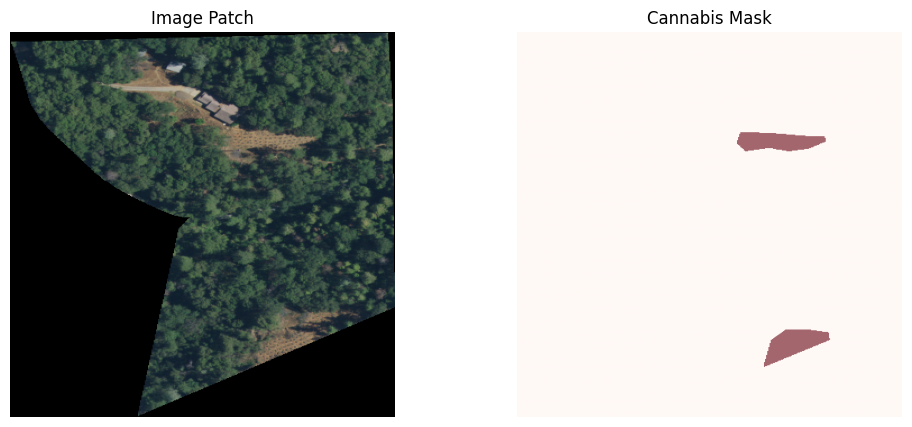

In [312]:
# ────────── Sample one patch manually ──────────

import json, numpy as np, rasterio, matplotlib.pyplot as plt
from rasterio.transform import xy
from rasterio.features import rasterize
from shapely.geometry import Polygon

# 1) tranformation for labelme images to a coordinate reference system
def labelme_points_to_geopolygon(points, transform):
    return Polygon([xy(transform, y, x) for x, y in points])

# 2) Instantiate dataset (make sure you've run the fixed class definition)
dataset = CannabisSegmentationGeoDataset(
    annotations_dir="../cannabis-parcels/cannabis-parcels-masked",
    naip_root="../cannabis-parcels/cannabis-parcels-masked",
    transforms=None
)

# 3) Grab the first annotation file + JSON
ann_path = dataset.annotation_paths[4]
ann = json.load(open(ann_path))
img_path = dataset.image_paths[ann_path]

# 4) Open the NAIP tile and get the first "cannabis" polygon
with rasterio.open(img_path) as src:
    image = src.read()
    win_t = src.transform

# 5) Rasterize the mask for all cannabis shapes in that window
_, h, w = image.shape
mask = np.zeros((h, w), dtype=np.uint8)
for shape in ann["shapes"]:
    if shape["label"] != "cannabis - old":
        p = labelme_points_to_geopolygon(shape["points"], src.transform)

        # Print info to debug
        print("Polygon bounds:", p.bounds)
        print("Do they intersect?", p.intersects(box(*src.bounds)))

        # Clip the polygon to the window
        p_window = p.intersection(box(*src.bounds))

        print("Image shape (bands, height, width):", image.shape)
        print("Rasterizing to shape:", (h, w))

        # Proceed only if there's something to rasterize
        if not p_window.is_empty:
            single = rasterize(
                [(p_window, 1)],
                out_shape=(h, w),
                transform=win_t,
                all_touched=True,
                dtype=np.uint8
            )
            print("Single shape max:", np.max(single))
            mask = np.maximum(mask, single)
            print("Mask max:", np.max(mask))
        else:
            print("Polygon is empty after intersection")

# 6) Plot
if image.ndim == 3 and image.shape[0] in [3, 4]:
    image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[..., :3], extent=src.bounds)
plt.title("Image Patch")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="Reds", alpha=0.6, extent=src.bounds)
plt.title("Cannabis Mask")
plt.axis("off")
plt.show()

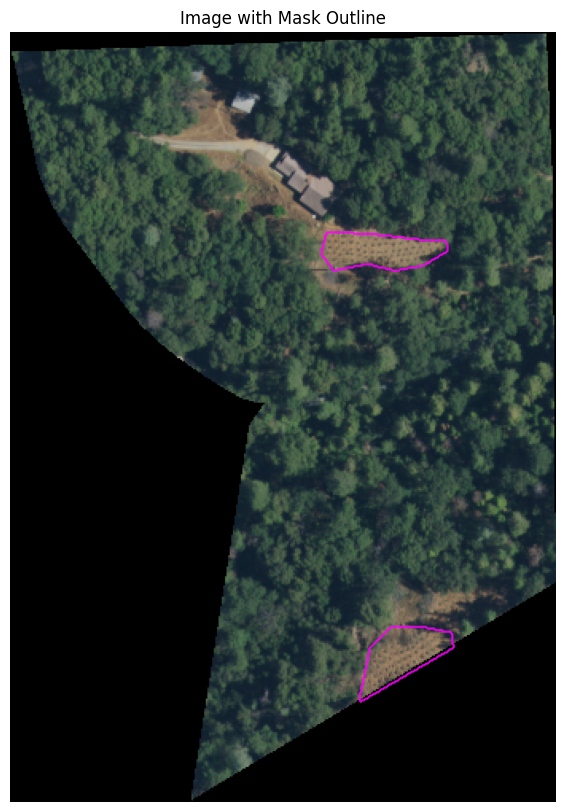

In [313]:
import matplotlib.pyplot as plt
import numpy as np

# image: shape (H, W, C), mask: shape (H, W)
# If image is CHW, convert to HWC for plotting
if image.shape[0] in [3, 4] and image.shape[0] < image.shape[1]:
    image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(10, 10))
plt.imshow(image[..., :3])  # Show only RGB channels if image has 4 channels
plt.contour(mask, colors='#FF00FF', linewidths=1, alpha=0.3)  # Outline mask in bright purple, adjust linewidth as needed
plt.title("Image with Mask Outline")
plt.axis("off")
plt.show()

../cannabis-parcels/cannabis-parcels-masked/10019035_20160620.json


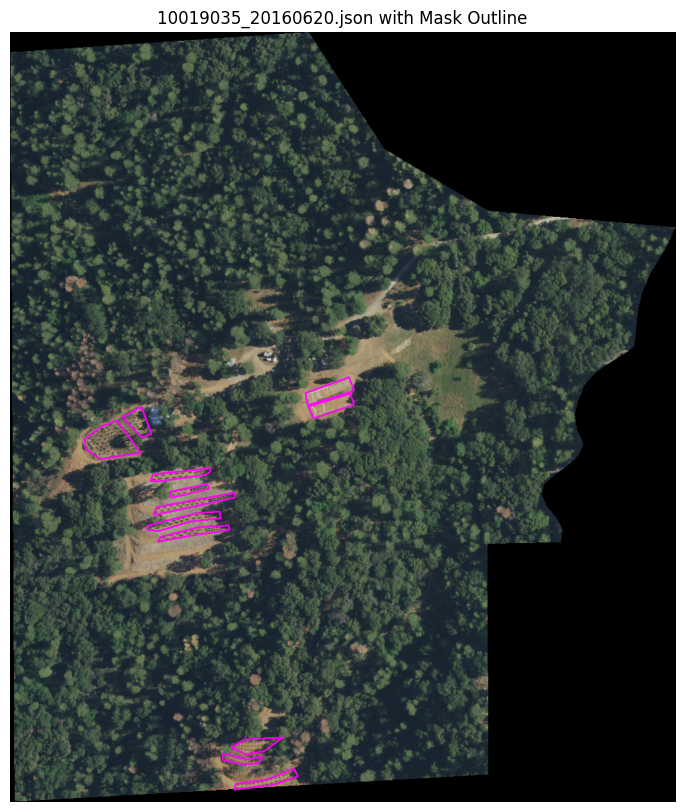

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import json
import rasterio

# Delete [:1] in the line below to get the full dataset
for ann_path in dataset.annotation_paths[:1]:
    print(ann_path)
    ann = json.load(open(ann_path))
    img_path = dataset.naip_root / ann["imagePath"]

    with rasterio.open(img_path) as src:
        image = src.read()  # Read full image
        h, w = image.shape[1:]
        # Rasterize full mask
        shapes = [
            (labelme_points_to_geopolygon(s["points"], src.transform), 1)
            for s in ann["shapes"] if s["label"] != "cannabis - old"
        ]
        mask = rasterio.features.rasterize(
            shapes,
            out_shape=(h, w),
            transform=src.transform,
            fill=0,
            dtype="uint8",
        )

    # Convert image to HWC for plotting if needed
    if image.shape[0] in [3, 4] and image.shape[0] < image.shape[1]:
        image = np.transpose(image, (1, 2, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(image[..., :3])
    plt.contour(mask, colors='#FF00FF', linewidths=1, alpha=0.3)
    plt.title(f"{ann_path.name} with Mask Outline")
    plt.axis("off")
    plt.show()

In [315]:
from typing import List, Tuple
import json, random, rasterio
from rasterio.transform import xy
from shapely.geometry import Polygon, box
from torchgeo.samplers import RandomGeoSampler

def labelme_points_to_geopolygon(points, transform):
    return Polygon([xy(transform, y, x) for x, y in points])

class PositiveNegativeGeoSampler(RandomGeoSampler):
    def __init__(self, dataset, size, length, pos_fraction=0.5):
        super().__init__(dataset, size, length)
        self.ds = dataset
        self.size = size
        self.length = length
        self.pos_frac = pos_fraction
        self.pos_bboxes: List[Tuple[float,float,float,float]] = []
        self.neg_bboxes: List[Tuple[float,float,float,float]] = []

        for ann_path in self.ds.annotation_paths:
            ann = json.load(open(ann_path))
            img_path = self.ds.image_paths[ann_path]
            with rasterio.open(img_path) as src:
                left, bottom, right, top = src.bounds
                rx, ry = src.res
                half_w = size/2 * rx
                half_h = size/2 * abs(ry)
                polys = []

                # positives: only if full window fits
                for shape_ in ann["shapes"]:
                    if shape_["label"] != "cannabis":
                        continue
                    poly = labelme_points_to_geopolygon(shape_["points"], src.transform)
                    polys.append(poly)
                    cx, cy = poly.centroid.x, poly.centroid.y
                    pb = (cx-half_w, cy-half_h, cx+half_w, cy+half_h)
                    if pb[0] >= left and pb[2] <= right and pb[1] >= bottom and pb[3] <= top:
                        self.pos_bboxes.append(pb)

                    # print("Patch bbox:", pb)
                    # print("Image bounds:", left, bottom, right, top)
                    # print("Patch width:", pb[2] - pb[0], "Patch height:", pb[3] - pb[1])
                    # print("Image width:", right - left, "Image height:", top - bottom)

                # negatives: random windows fully inside & not overlapping
                w, h = src.width, src.height
                for _ in range(max(1, len(polys)*2)):
                    for __ in range(50):
                        ix, iy = random.randint(0, w-1), random.randint(0, h-1)
                        cx2, cy2 = xy(src.transform, iy, ix)
                        nb = (cx2-half_w, cy2-half_h, cx2+half_w, cy2+half_h)
                        if (
                            nb[0] >= left and nb[2] <= right and
                            nb[1] >= bottom and nb[3] <= top and
                            not any(p.intersects(box(*nb)) for p in polys)
                        ):
                            self.neg_bboxes.append(nb)
                            break

    def __iter__(self):
        for _ in range(self.length):
            if random.random() < self.pos_frac and self.pos_bboxes:
                print("+", end="", flush=True)
                bbox = random.choice(self.pos_bboxes)
            else:
                print("-", end="", flush=True)
                bbox = random.choice(self.neg_bboxes)
            yield {"bbox": bbox, "size": self.size}

    def __len__(self):
        return self.length

+-+---++

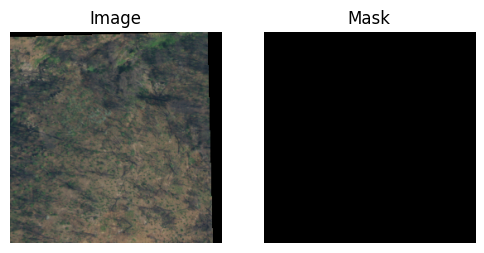

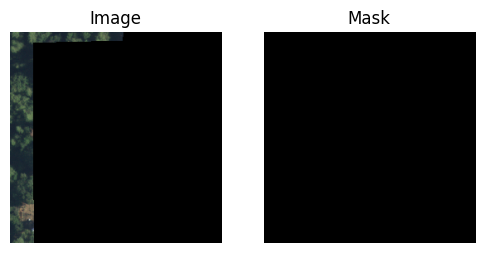

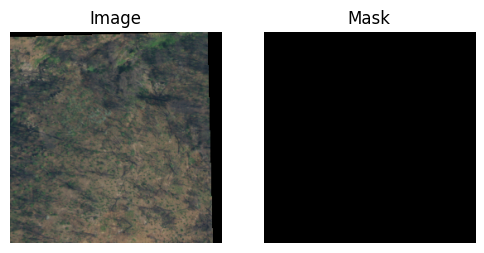

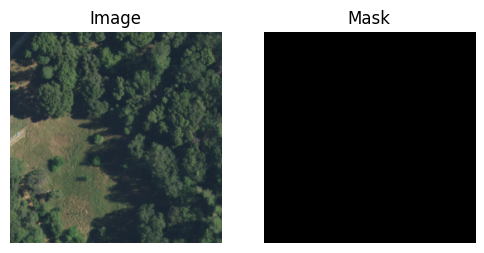

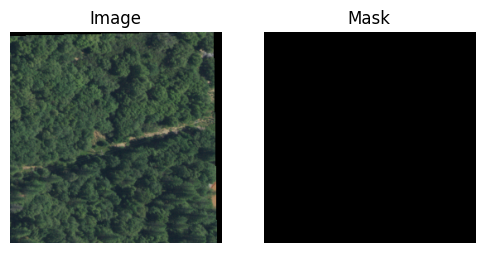

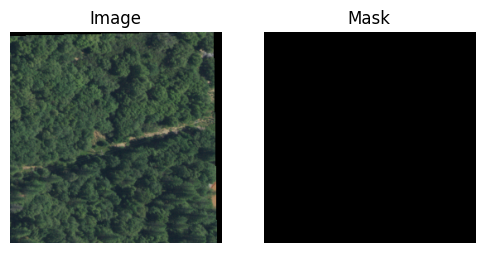

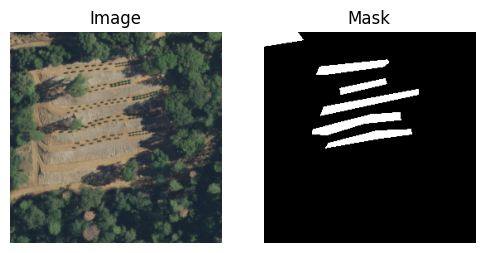

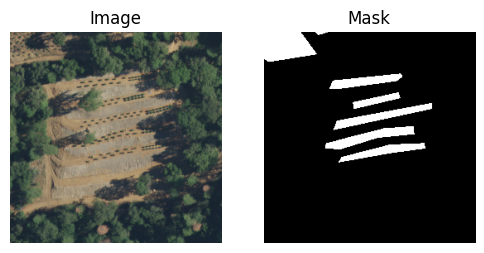

In [316]:
from torch.utils.data import DataLoader

# ─── Usage ───
patch_size = 256
sampler = PositiveNegativeGeoSampler(dataset, size=patch_size,
                                     length=10, pos_fraction=0.5)
loader = DataLoader(dataset, batch_size=8, sampler=sampler)

# Visualize one batch
batch = next(iter(loader))
imgs, msks = batch["image"], batch["mask"]

import matplotlib.pyplot as plt

for i in range(len(imgs)):
    img = imgs[i].cpu().numpy()
    if img.ndim==3 and img.shape[0] in [3,4]:
        img = img.transpose(1,2,0)
    msk = msks[i,0].cpu().numpy()   # pick channel 0 → shape (H,W)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img[..., :3]); plt.title("Image"); plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(msk, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.show()

## Data Augmentation

In [317]:
def get_transforms(patch_size):
    train_transform = A.Compose([
        A.RandomCrop(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    val_transform = A.Compose([
        A.CenterCrop(patch_size, patch_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    return train_transform, val_transform

In [318]:
## U-Net Model Architecture (unchanged)

import torch.nn.functional as F
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class UNetWithResNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=1, pretrained=True):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Modify first conv layer to accept 4 channels
        w = resnet.conv1.weight
        resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if n_channels == 4:
            resnet.conv1.weight.data[:, :3, :, :] = w.data
            resnet.conv1.weight.data[:, 3:, :, :].zero_()
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        self.center = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )
        self.decoder4 = DecoderBlock(2048, 1024, 1024)
        self.decoder3 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder1 = DecoderBlock(256, 64, 64)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, n_classes, kernel_size=1),
            nn.Sigmoid()
        )
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        input_size = x.size()[2:]
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        e0 = x
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e4 = self.center(e4)
        d4 = self.decoder4(e4, e3)
        d3 = self.decoder3(d4, e2)
        d2 = self.decoder2(d3, e1)
        d1 = self.decoder1(d2, e0)
        out = self.final_conv(d1)
        out = self.final_up(out)
        if out.size()[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        return out

In [319]:
## Training Loop (unchanged)

from torch.utils.data import DataLoader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    num_epochs: int,
    device: torch.device
) -> Tuple[List[float], List[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        for batch_idx, batch in enumerate(train_loader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device).float()
            if batch_idx == 0 and epoch == 0:
                print(f"\nInput shapes:")
                print(f"Images: {images.shape}")
                print(f"Masks: {masks.shape}")
            optimizer.zero_grad()
            outputs = model(images)
            if batch_idx == 0 and epoch == 0:
                print(f"Outputs: {outputs.shape}\n")
                assert outputs.shape == masks.shape, \
                    f"Shape mismatch: outputs {outputs.shape} vs masks {masks.shape}"
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1
        train_loss = epoch_loss / batch_count
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        val_count = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                masks = batch["mask"].to(device).float()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_count += 1
        val_loss = val_loss / val_count
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 40)
    return train_losses, val_losses

## Main Training Script

In [320]:
def main():
    patch_size = 256  # or whatever your crop size is
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    naip_root = "../cannabis-parcels/cannabis-parcels-masked"
    annotations_dir = "../cannabis-parcels/cannabis-parcels-masked"
    train_transform, val_transform = get_transforms(patch_size)
    train_dataset = CannabisSegmentationGeoDataset(
        naip_root=naip_root,
        annotations_dir=annotations_dir,
        transforms=train_transform
    )
    val_dataset = CannabisSegmentationGeoDataset(
        naip_root=naip_root,
        annotations_dir=annotations_dir,
        transforms=val_transform
    )
    # Use RandomGeoSampler
    train_sampler = PositiveNegativeGeoSampler(train_dataset, size=patch_size, length=25)  # adjust length as needed
    val_sampler = PositiveNegativeGeoSampler(val_dataset, size=patch_size, length=11)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, sampler=val_sampler)
    # Model, loss, optimizer (use new UNetWithResNet)
    model = UNetWithResNet(n_channels=4, n_classes=1, pretrained=True).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,
        device=device
    )
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), "cannabis_segmentation_model.pth")

In [ ]:
if __name__ == "__main__":
    main()

+-++

/Users/wxmiked/vscode-workspace/cannabis/cannabis-deforestation/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Input shapes:
Images: torch.Size([4, 4, 256, 256])
Masks: torch.Size([4, 1, 256, 256])
Outputs: torch.Size([4, 1, 256, 256])

-+-+-+--+-++-++--++----++-+--+--Epoch 1/50
Train Loss: 0.5701
Val Loss: 0.6211
Learning Rate: 0.000100
----------------------------------------
-++--+--+-+---++-+++-+-++++++---+-+-Epoch 2/50
Train Loss: 0.5369
Val Loss: 0.5728
Learning Rate: 0.000100
----------------------------------------
-+--+--+---+---++-----+++--++++-+--+Epoch 3/50
Train Loss: 0.5252
Val Loss: 0.5606
Learning Rate: 0.000100
----------------------------------------
+-++++------++---+++--++-++++-+-+--+Epoch 4/50
Train Loss: 0.5134
Val Loss: 0.5699
Learning Rate: 0.000100
----------------------------------------
+---+---------------+-+---++--+-+-++Epoch 5/50
Train Loss: 0.4993
Val Loss: 1.1859
Learning Rate: 0.000100
----------------------------------------
+---++--+-+-+---++---+--------+-++++Epoch 6/50
Train Loss: 0.4807
Val Loss: 0.8419
Learning Rate: 0.000100
------------------------------